In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils
# mpl_stylesheet.banskt_presentation(fontfamily = 'system')
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'tejaas_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas_rand', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm_sp':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr_it1.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm_sp':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr_it1.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'cpma':
            filepath = os.path.join(datadir, 'tejaas', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'cpma_rand':
            filepath = os.path.join(datadir, 'tejaas_rand', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)
        elif method == 'matrixeqtl_rand':
            filepath = os.path.join(datadir, 'matrixeqtl_rand', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

def update_sparse_dict(old_dict, new_dict):
    for key in new_dict.keys():
        if old_dict.get(key, False):
            old_dict[key] = new_dict[key]
        else:
            print("SNP {:s} not present".format(key))
    return old_dict

def get_dict_for_no_crxn(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


@timeit
def validate(testdict, valdict, smax = -np.log10(0.05), nmax = None, empirical = False, empirical_percent = 5):
    if empirical:
        percent_fraction = 100/empirical_percent
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/percent_fraction))
            print("totsnps:", totsnps, " nmax:", nmax)
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list(data.values())
    return datalist

@timeit
def validate_old(testdict, valdict, smax = -np.log10(0.05), nmax = None, empirical = False):
    if empirical:
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/20))
            print("totsnps:", totsnps, " nmax:", nmax)
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list()
    for key, value in data.items():
        datalist.append(value)
    return datalist

In [3]:
import itertools 

chrms = [1,2,3,6,7,8,9,10]
# chrms = np.arange(1,23)
# datasets = ['gtex-as', 'gtex-at', 'gtex-aa']

datasets = ["gtex-aa", "gtex-at"]
methods = [ "tejaas_perm", "tejaas_rand_perm", 'matrixeqtl', 'matrixeqtl_rand'] #'tejaas_perm', 'tejaas_rand_perm','tejaas_perm', 'tejaas_rand_perm', 'tejaas_rand_perm', 'matrixeqtl', 'matrixeqtl_fdr', 'matrixeqtl_rand', "cpma"]
# methods = ['matrixeqtl']
sbs = ["0.05"]
eps = [0.05]
# input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/lmcorrected'
expressions = ["norm"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/'+expr

combi = [x for x in itertools.combinations(datasets,2)]

In [4]:
# Load all datasets first
allmethods = list()
data = collections.defaultdict(dict)
for dataset in datasets:
    for key in methods:
        if key.startswith("tejaas"):
            for sb in sbs:
                mkey = key + "_" + sb
                print("Loading",mkey)
                if input_dir.endswith('uncorrected'):
                    data[dataset][mkey] = get_dict_for_no_crxn(key, input_dir, chrms, dataset, sb)
                else:
                    data[dataset][mkey] = get_dict_for_method(key, input_dir, chrms, dataset, sb)
                if mkey not in allmethods: allmethods.append(mkey) 
                # broken...
                # if key.endswith("_sp"):
                #     print("going with ", dataset, mkey)
                #     data[dataset][key] = update_sparse_dict(data[dataset][key.rstrip("_sp")].copy(), data[dataset][key])
        else:
            print("Loading",key)
            if input_dir.endswith('uncorrected'):
                data[dataset][key] = get_dict_for_no_crxn(key, input_dir, chrms, dataset)
            else:
                data[dataset][key] = get_dict_for_method(key, input_dir, chrms, dataset)
            if key not in allmethods: allmethods.append(key) 

Loading tejaas_perm_0.05
Reading gtex-aa for tejaas_perm
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr1/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr2/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr3/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr8/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr9/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-aa/tejaas/permnull_sb0.05/chr10/rr.txt
Loading tejaas_rand_perm_0.05
Reading gtex-aa 

In [5]:
res = collections.defaultdict(dict)
tissue_pairs = []
for combination in combi:
    tissue_pair = combination[0]+"_"+combination[1]
    tissue_pairs.append(tissue_pair)
    for key in methods:
        if key.startswith("tejaas"):
            for sb in sbs:
                mkey = key + "_" + sb 
                print(mkey, tissue_pair)    
                res[tissue_pair][mkey] = collections.defaultdict(dict)
                res[tissue_pair][mkey]['test']     = data[combination[0]][mkey]
                res[tissue_pair][mkey]['crossval'] = data[combination[1]][mkey]
        else:
            print(key, tissue_pair)    
            res[tissue_pair][key] = collections.defaultdict(dict)
            res[tissue_pair][key]['test']     = data[combination[0]][key]
            res[tissue_pair][key]['crossval'] = data[combination[1]][key]

tejaas_perm_0.05 gtex-aa_gtex-at
tejaas_rand_perm_0.05 gtex-aa_gtex-at
matrixeqtl gtex-aa_gtex-at
matrixeqtl_rand gtex-aa_gtex-at


In [6]:
valres = collections.defaultdict(dict)
for tissue_pair in tissue_pairs:
    for key in methods:
        if key.startswith("tejaas"):
            for sb in sbs: 
                mkey = key + "_" + sb 
                valres[tissue_pair][mkey] = collections.defaultdict(dict)
                print("Validating {:s} {:s}".format(mkey, tissue_pair))
                testdict, valdict = utils.get_compatible_snp_dicts(res[tissue_pair][mkey]['test'], res[tissue_pair][mkey]['crossval'])
                valres[tissue_pair][mkey] = validate(testdict, valdict, empirical=True, smax = -np.log10(0.01), empirical_percent = eps[0])
        else:
            valres[tissue_pair][key] = collections.defaultdict(dict)
            print("Validating {:s} {:s}".format(key, tissue_pair))
            testdict, valdict = utils.get_compatible_snp_dicts(res[tissue_pair][key]['test'], res[tissue_pair][key]['crossval'])
            valres[tissue_pair][key] = validate(testdict, valdict, empirical=True, smax = -np.log10(0.01), empirical_percent = eps[0])

Validating tejaas_perm_0.05 gtex-aa_gtex-at
get_compatible_snp_dicts took: 3.463819 seconds
totsnps: 1996620  nmax: 998
validate took: 9.802260 seconds
Validating tejaas_rand_perm_0.05 gtex-aa_gtex-at
get_compatible_snp_dicts took: 3.372921 seconds
totsnps: 2004692  nmax: 1002
validate took: 9.321368 seconds
Validating matrixeqtl gtex-aa_gtex-at
get_compatible_snp_dicts took: 3.517304 seconds
totsnps: 1945311  nmax: 973
validate took: 7.406332 seconds
Validating matrixeqtl_rand gtex-aa_gtex-at
get_compatible_snp_dicts took: 3.388899 seconds
totsnps: 1867270  nmax: 934
validate took: 8.886610 seconds


In [7]:
allmethods

['tejaas_perm_0.05', 'tejaas_rand_perm_0.05', 'matrixeqtl', 'matrixeqtl_rand']

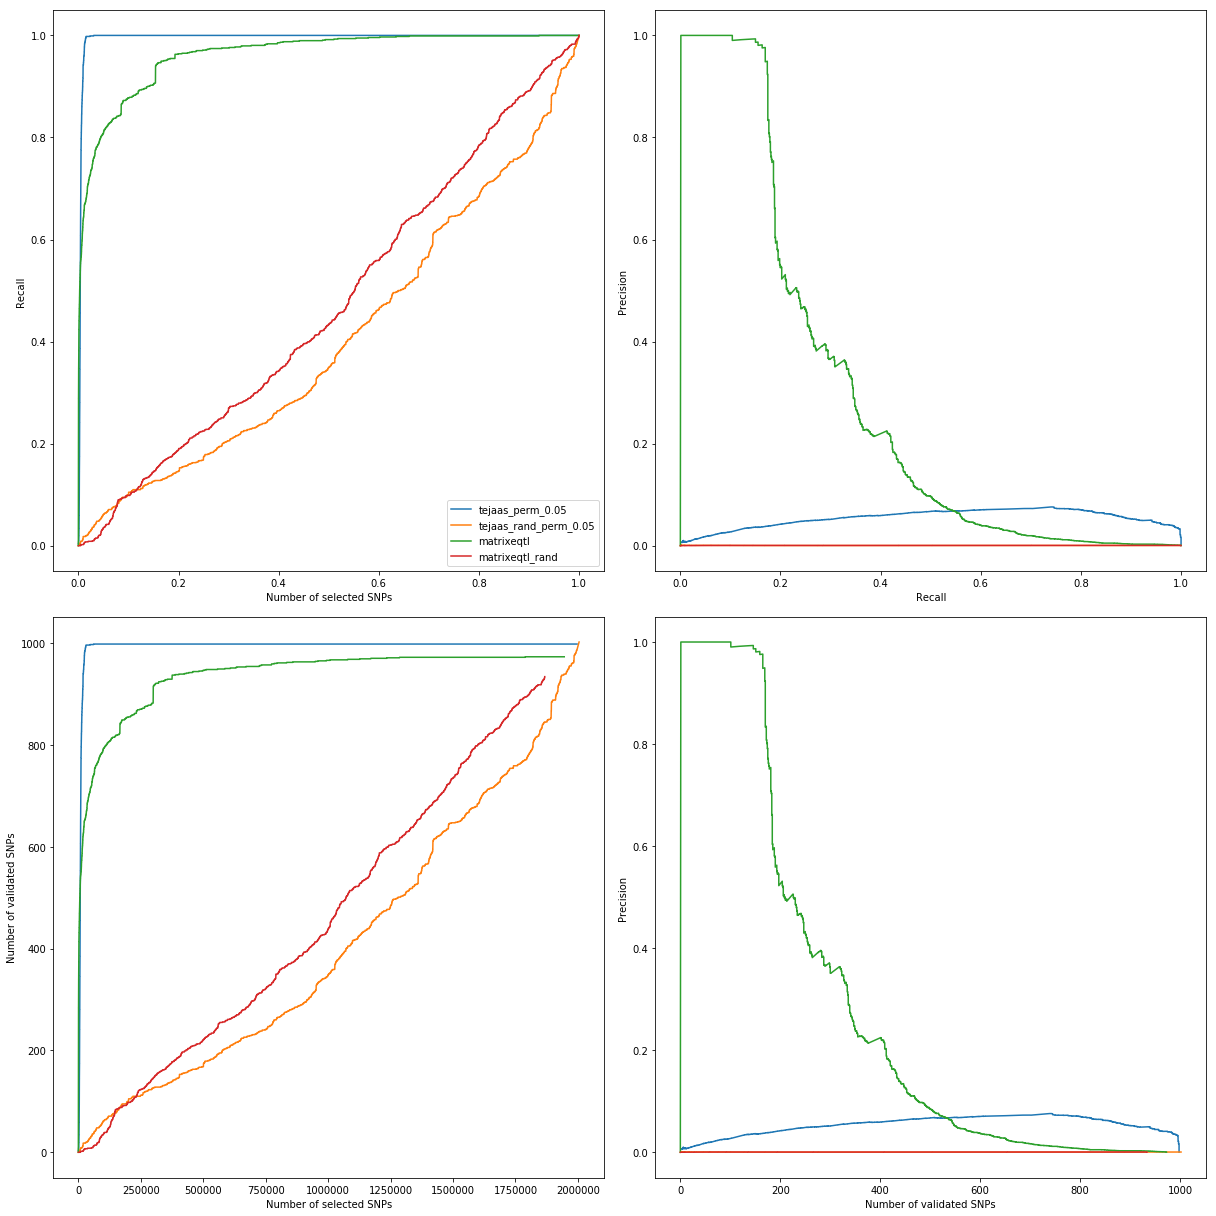

In [8]:

fig = plt.figure(figsize = (17, 17))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# plot_methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr',
#                 'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
# plot_methods = ['tejaas_perm', '']

tissue_pair = 'gtex-aa_gtex-at'
# outfile = "../plots/test_"+expr+"_"+tissue_pair+".png"
outfile = "../plots/meqtl_test_"+expr+"_"+tissue_pair+".png"

# tissue_pair = 'gtex-as_gtex-at'
for key in allmethods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
    scaled_nsel = nsel / max(nsel)
    ax1.plot(scaled_nsel, tpr, label =key)
    ax2.plot(tpr, ppv, label = key)
    ax3.plot(nsel, valids, label = key)
    ax4.plot(valids, ppv, label = key)

#         nsel2, tpr2, ppv2, valids2 = roc.confusion_matrix(valres2[tissue_pair][mkey])
#         scaled_nsel2 = nsel2 / max(nsel2)
#         ax1.plot(scaled_nsel2, tpr2, label =mkey+"2")
#         ax2.plot(tpr2, ppv2, label = mkey+"2")
#         ax3.plot(nsel2, valids2, label = mkey+"2")
#         ax4.plot(valids2, ppv2, label = mkey+"2")

    
mlabel = r'Number of selected SNPs'
ax1.set_xlabel(mlabel)
ax3.set_xlabel(mlabel)
mlabel = r'Recall'
ax1.set_ylabel(mlabel)
ax2.set_xlabel(mlabel)
mlabel = r'Number of validated SNPs'
ax4.set_xlabel(mlabel)
ax3.set_ylabel(mlabel)
mlabel = r'Precision'
ax2.set_ylabel(mlabel)
ax4.set_ylabel(mlabel)

#ax2.set_xlim([0, 1000])
#ax1.set_xlim([0, 10000])
#ax1.set_ylim([0, 5000])
ax1.legend()
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

tejaas_perm_0.05
tejaas_rand_perm_0.05
matrixeqtl
matrixeqtl_rand


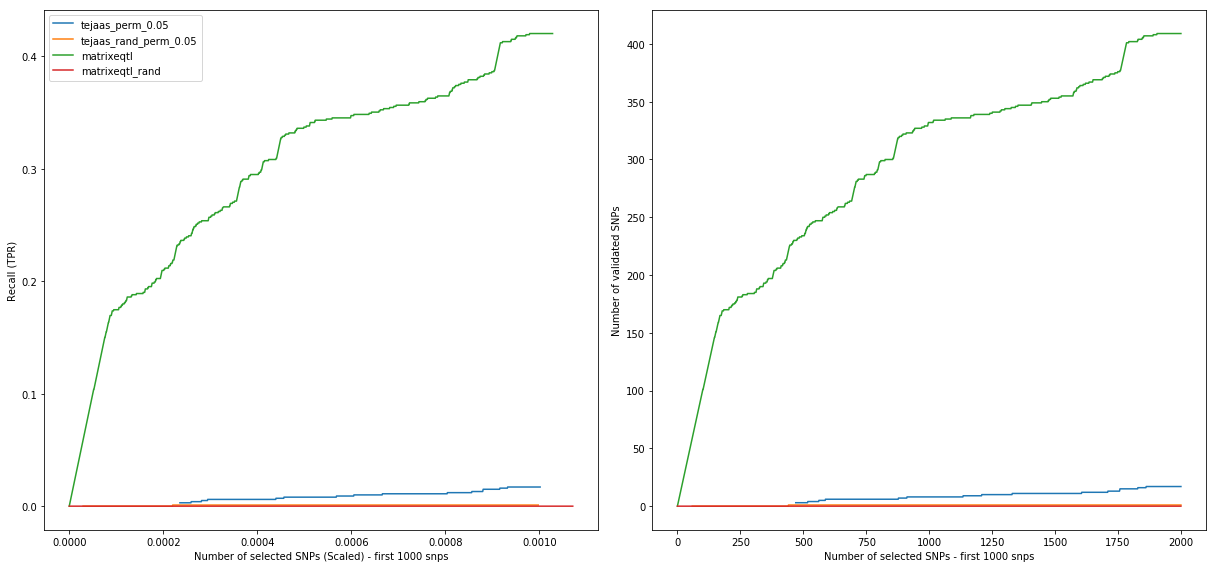

In [9]:
#outfile = 'gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01_chr-7-8.pdf'
#outfile = 'validation_methods_comparison_matrixeqtl_ms_hlv_no_correction.png'

fig = plt.figure(figsize = (17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
tissue_pair = 'gtex-aa_gtex-at'
outfile = "../plots/meqtl_test_"+expr+"_"+tissue_pair+"_n2000.png"

for key in allmethods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
    scaled_nsel = nsel / max(nsel)
    #ax1.plot(scaled_nsel, tpr, label = key)
    #ax2.plot(tpr, ppv, label = key)
    Nmax = min(2000, len(nsel)-1)
    ix = nsel < Nmax
    x = np.append(nsel[ ix ], Nmax)
    xscaled  = np.append(scaled_nsel[ ix ], Nmax/max(nsel))

    y = np.append(valids[ ix ], valids[ np.sum(ix)])
    ytpr = np.append(tpr[ ix ],    tpr[ np.sum(ix)])
    print(key)
    ax1.plot(xscaled, ytpr, label = key)
    ax2.plot(x, y, label = key)

mlabel = r'Number of selected SNPs (Scaled) - first 1000 snps'
ax1.set_xlabel(mlabel)
mlabel = r'Number of selected SNPs - first 1000 snps'
ax2.set_xlabel(mlabel)
mlabel = r'Recall (TPR)'
ax1.set_ylabel(mlabel)
mlabel = r'Number of validated SNPs'
ax2.set_ylabel(mlabel)

# ax1.set_xlim([0, 100])
# ax1.set_ylim([0, 60])
ax1.legend()
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [36]:
from sklearn import metrics
import scipy.integrate as integrate

print(xscaled.shape)
print(ytpr.shape)

print(metrics.auc(xscaled, ytpr))
aucpart = integrate.trapz(ytpr, xscaled)
random_area = integrate.trapz([0, max(xscaled)], [0, max(xscaled)])
print(random_area)
print(aucpart/(2*random_area))

(1324,)
(1324,)
6.36720074491413e-05
7.2728222478253955e-06
4.377393347416095


In [10]:
from sklearn import metrics

aucs   = dict()
aucs1k = dict()

method_dict = collections.defaultdict(lambda: np.zeros((len(datasets),len(datasets))))
matrix_dict = dict(zip(datasets, np.arange(len(datasets))))

tissue_pair = 'gtex-as_gtex-at'
for key in allmethods:
    auc_array = np.zeros((len(datasets),len(datasets)))
    for tissue_pair in tissue_pairs:
        i = matrix_dict[tissue_pair.split("_")[0]]
        j = matrix_dict[tissue_pair.split("_")[1]]
        nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
        scaled_nsel = nsel / max(nsel)
        auc = metrics.auc(scaled_nsel, tpr)
        ix = nsel < 1000
        xscaled  = np.append(scaled_nsel[ ix ], 1000/max(nsel))
        ytpr = np.append(tpr[ ix ], tpr[ np.sum(ix)])
        auc1k = metrics.auc(xscaled, ytpr)
        auc_array[j,i] = auc
        aucs[key] = auc
        aucs1k[key] = auc1k
        print(tissue_pair, key, auc, auc1k)
    method_dict[key] = auc_array

gtex-as_gtex-at matrixeqtl 0.5649981431407811 8.319632664379916e-07
gtex-as_gtex-aa matrixeqtl 0.5425877656941137 7.958774613979894e-07
gtex-at_gtex-aa matrixeqtl 0.5536361812970683 8.875464421450587e-07


In [ ]:
from sklearn import metrics

aucs   = dict()
aucs1k = dict()

method_dict = collections.defaultdict(lambda: np.zeros((len(datasets),len(datasets))))
matrix_dict = dict(zip(datasets, np.arange(len(datasets))))

def calc_auc(nsel, tpr, n=1000):
    scaled_nsel = nsel / max(nsel)
    auc = metrics.auc(scaled_nsel, tpr)
    ix = nsel < n
    xscaled  = np.append(scaled_nsel[ ix ], n/max(nsel))
    ytpr = np.append(tpr[ ix ], tpr[ np.sum(ix)])
    auc1k = metrics.auc(xscaled, ytpr)
    return auc, auc1k

tissue_pair = 'gtex-as_gtex-at'
sbs = ['0.01', '0.05']
for sb in sbs:
    for key in plot_methods:
        auc_array = np.zeros((len(datasets),len(datasets)))
        for tissue_pair in tissue_pairs:
            mkey = key + "_" + sb 
            i = matrix_dict[tissue_pair.split("_")[0]]
            j = matrix_dict[tissue_pair.split("_")[1]]
            nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][mkey])
            nsel2, tpr2, ppv, valids = roc.confusion_matrix(valres2[tissue_pair][mkey])
            auc, auc1k = calc_auc(nsel, tpr)
            auc2, auc1k2 = calc_auc(nsel2, tpr2)
            auc_array[j,i] = auc
            aucs[mkey] = auc
            aucs1k[mkey] = auc1k
            print(tissue_pair, mkey, auc, auc2)
        method_dict[mkey] = auc_array

In [ ]:
N = len(datasets)

key1 = "tejaas_perm"
key2 = "cpma"
method_array = method_dict[key1] + method_dict[key2].T

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
im = ax.imshow(method_array)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(datasets, fontsize=14)
ax.set_yticklabels(datasets, fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(N):
    for j in range(N):
        text = ax.text(j, i, "{:.2f}".format(method_array[i, j]),
                       ha="center", va="center", color="w", fontsize=14)

ax.set_title("Tissue-Tissue validation AUC", fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
N = len(datasets)

mkey1 = "tejaas_perm"
mkey2 = "cpma"
method_array = method_dict[key1] + method_dict[key2].T


cmap = plt.cm.RdBu_r
norm = plt.Normalize(method_array.min(), method_array.max())
rgba = cmap(norm(method_array))
rgba[range(N), range(N), :3] = 0.7,0.7,0.7
im = ax.imshow(rgba)

# Add the colorbar using a fake (not shown) image
im = ax.imshow(method_array, visible=False, cmap="RdBu_r")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("AUC", rotation=-90, va="bottom")

# delete axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',which='both',left=False)
ax.tick_params(axis='x',which='both',bottom=False)

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(datasets, fontsize=14, color="black")
ax.set_yticklabels(datasets, fontsize=14, color="black")
bbox = dict(boxstyle="round", alpha=0.9, ec="white", fc="white")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center",
        rotation_mode="anchor", bbox=bbox)
plt.setp(ax.get_yticklabels(), bbox=bbox)

# ax.tick_params(axis='x', colors='red')
# my_colors = ['#FFF000', 'b', 'r', 'r', 'g', 'k']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_backgroundcolor(tickcolor)
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors):
    ticklabel.set_backgroundcolor(tickcolor)

# for i in range(N):
#     for j in range(N):
#         text = ax.text(j, i, "{:.3f}".format(method_array[i, j]).replace("{:.3f}".format(method_array.min()), ""),
#                        ha="center", va="center", color="w", fontsize=14)

ax.set_title("Tissue-Tissue validation AUC", fontsize=14)
fig.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()